# <font color='royalblue'> B. Does silencing the cingulate cortex during a test run leads to performance impairments? (timeouts removed)

### <font color='firebrick'> Imports

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
from file_lists import get_file_list
%matplotlib inline
%run data_prep_functions.ipynb

### <font color='royalblue'> Read the data (test runs below 15 seconds)

In [12]:
file_path = "E:\POSITION DATA\PRE PROCESSED/below15_runs.csv"
below15 = pd.read_csv(file_path)
below15.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_entry,latency_to_cp_exit,time_in_cp
0,2019-08-08T12_41_07,NPHR1,6.0,368.579635,T,1,1.0,NPHR,371.569088,372.640947,2.989453,4.061312,1.071859
1,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,3.917466,4.913382,0.995917
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,3.781990,4.815962,1.033971


### <font color='royalblue'>Remove pre-illuminated and sample illuminated trials


In [13]:
below15 = below15[(below15['stim_condition']==0)|(below15['stim_condition']==3)]
below15['stim_condition'].unique()

array([3, 0], dtype=int64)

### <font color='royalblue'> Calculate the performances

In [14]:
# Calculate performances for each rat, session and stimulation condition
session_perfs = below15.groupby(['group','rat','session', 'stim_condition']).apply(calc_performance_in_group)
session_perfs = session_perfs.reset_index().rename(columns={0:'performance'})

### <font color='firebrick'> Input

In [15]:
pooled_perfs = session_perfs.groupby(['group', 'rat', 'stim_condition'])['performance'].mean().reset_index()

### Performance within groups

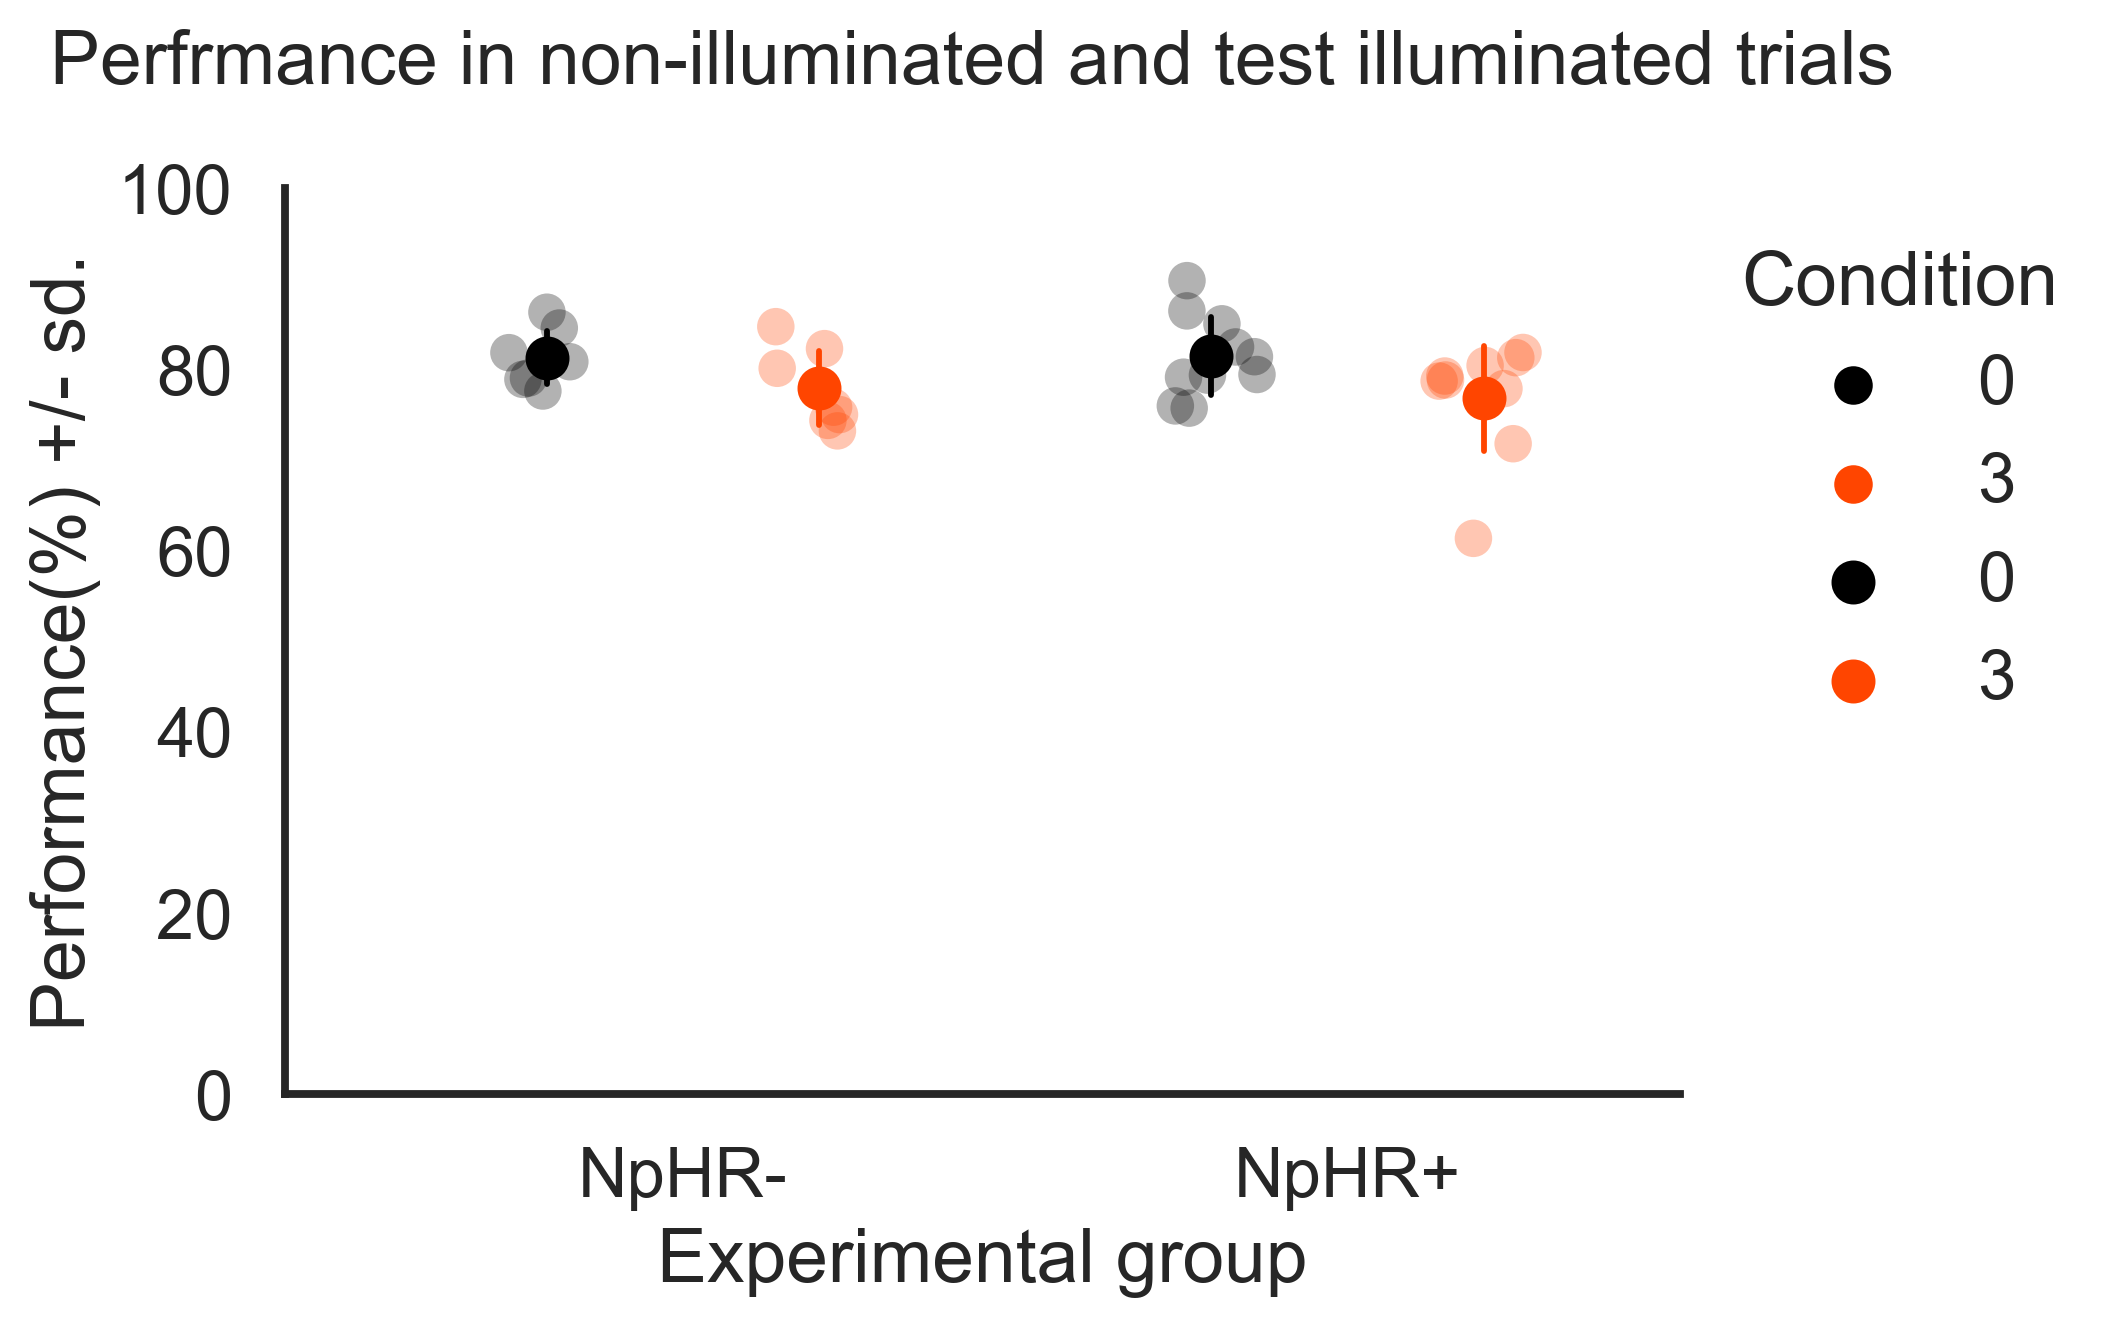

In [16]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(6,4), dpi=300)

g = sns.stripplot(
    data=pooled_perfs, x='group', y='performance', hue='stim_condition',
    dodge=2, jitter=.13, alpha=.3, s=9, palette=['black', 'orangered'], order=['CTRL', 'NPHR']
)
# Show means
sns.pointplot(
    x='group', y='performance', hue='stim_condition',
    data=pooled_perfs, dodge=.41, join=False, markers="o", scale=.8, 
    estimator=np.mean, ci="sd", errwidth=1.4, palette=['black', 'orangered'], order=['CTRL', 'NPHR']
)

g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Experimental group',
    ylim=(0, 100), xlim=(-0.6, 1.5), xticks=[0,1], xticklabels= ['NpHR-', 'NpHR+'],
    title='Perfrmance in non-illuminated and test illuminated trials \n'
)
plt.legend(frameon=False)
g.legend_.set(bbox_to_anchor=[1,1],title='Condition')
sns.despine()

CTRL  0        (0.934409499168396, 0.5889925956726074)
      3      (0.8992706537246704, 0.32658737897872925)
NPHR  0        (0.9476720690727234, 0.641046404838562)
      3    (0.7464005947113037, 0.0032261130400002003)
dtype: object

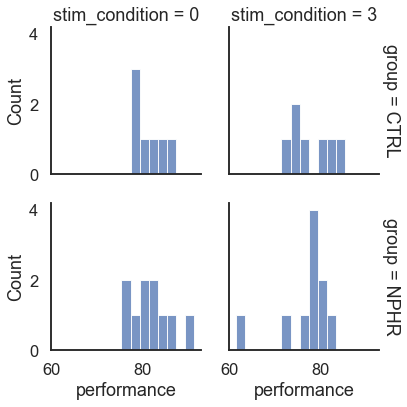

In [17]:
sns.displot(
    pooled_perfs, x="performance", col="stim_condition", row="group",
    binwidth=2, height=3, facet_kws=dict(margin_titles=True),
)

from scipy.stats import shapiro

normality_testing = {}
for group, data in pooled_perfs.groupby(['group', 'stim_condition'])['performance']:
    stat, p = shapiro(data)
    normality_testing[group] = (stat, p)

normality_testing = pd.Series(normality_testing)
normality_testing

##### The shapiro-Wilk test has confirmed that all but one distribution (NpHR+ , illumination condition) could have been withdrawn from a normal distribution (checked visually above too). Because for one of the distributions the null hypothesis was rejected, I performed two transformations in the four data distributions from pooled performance - square-root and log(e)/(10). I found that these transformations did not transform the NPHR+/illumination distribution into a distribution of data points that could have been withdrawn from a normal distribution, shown by the shapiro-Wilk test.
##### I will resort to a non-parametric test, namely the Wilcoxon signed rank test, to compare the performance of subjects within each group, across the two experimental conditions. (two-tailed)

In [19]:
# NpHR - group
from scipy.stats import wilcoxon
ctrl_no_illum = pooled_perfs[(pooled_perfs['group']=='CTRL') & (pooled_perfs['stim_condition']==0)]
ctrl_illum = pooled_perfs[(pooled_perfs['group']=='CTRL') & (pooled_perfs['stim_condition']==3)]
diff = ctrl_no_illum['performance']-ctrl_illum['performance']
w, p = wilcoxon(x=ctrl_no_illum['performance'], y=ctrl_illum['performance'])
print(w, p)

# NpHR+ group
nphr_no_illum = pooled_perfs[(pooled_perfs['group']=='NPHR') & (pooled_perfs['stim_condition']==0)]
nphr_illum = pooled_perfs[(pooled_perfs['group']=='NPHR') & (pooled_perfs['stim_condition']==3)]
diff = nphr_no_illum['performance'] - nphr_illum['performance']

w, p = wilcoxon(x=nphr_no_illum['performance'], y=nphr_illum['performance'])
print(w, p)

1.0 0.03125
2.0 0.005859375


## 1.2 individual variability

Text(0.5, 1.0, 'NpHR+')

<Figure size 1800x1200 with 0 Axes>

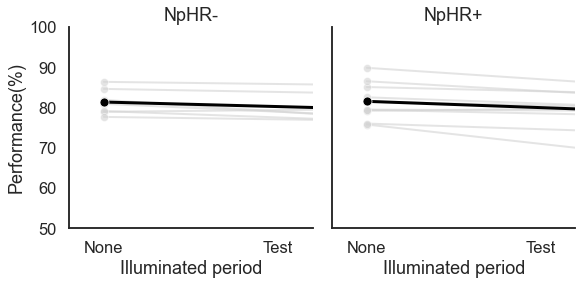

In [20]:
sns.set(style="white", context='talk')    
plt.figure(dpi=300)
colors = ['lightgray']*17 # Needs adjusting as more rats are added
g = sns.relplot(
    data=pooled_perfs, col='group',
    x='stim_condition', y='performance', hue='rat', kind='line',
    linewidth=2, marker='o', markersize=8, alpha=.6,
    palette=colors, legend=False, height=4, aspect=1
)
for group, ax in g.axes_dict.items():
    sns.lineplot(data=pooled_perfs[pooled_perfs['group']==group], 
                 x='stim_condition', y='performance', marker='o',
                 estimator=np.mean, ci=None, color='black', linewidth=3, ax=ax)

g.set(
    ylabel='Performance(%)', xlabel='Illuminated period',
    ylim=(50, 100), xlim=(-.2, 1.2), xticks=[0,1],
    xticklabels=['None', 'Test']
)
axes = g.axes.flatten()
axes[0].set_title("NpHR-")
axes[1].set_title("NpHR+")

## 1.3. % Variation

In [21]:
no_illumin = pooled_perfs[pooled_perfs['stim_condition']=='0'].reset_index(drop=True)
test_illumin = pooled_perfs[pooled_perfs['stim_condition']=='3'].reset_index(drop=True)
diff = test_illumin['performance']-no_illumin['performance']
pooled_perf_diffs = pd.concat([no_illumin[['group', 'rat']], diff], axis=1)

In [22]:
plt.Figure(figsize=(5,7))
sns.set(style='white', context='talk')

# Add bars
g = sns.barplot(data=pooled_perf_diffs, x='group', y='performance',
           ci='sd', errwidth=3,
            palette=['gray', 'gray'], alpha=.4)
# Add individual dots
g = sns.stripplot(
    x='group', y='performance',
    data=pooled_perf_diffs,
    dodge=2, jitter=.07,
    alpha=.7, s=10,
    palette=['black', 'black'],
    order=['CTRL', 'NPHR']
)
# Add horizontal line (= zero deviation)
plt.axhline(0, 0, 2, linestyle='dashed', color='black')

# Add specs
g.set(ylabel='Performance variation', xlabel='Experimental group',
     title='Peformance variation upon test run illumination\n',
     xticks=[0,1], xticklabels=['NpHR-', 'NpHR+'], xlim=[-.8,1.8], ylim=[-20, 5])

sns.despine()

ValueError: min() arg is an empty sequence

In [ ]:
from scipy.stats import shapiro

normality_testing = {}
for group, data in pooled_perf_diffs.groupby(['group'])['performance']:
    stat, p = shapiro(data)
    normality_testing[group] = (stat, p)

normality_testing = pd.Series(normality_testing)
normality_testing

In [ ]:
from scipy.stats import ttest_ind
ctrl_var = pooled_perf_diffs[pooled_perf_diffs['group']=='CTRL']
nphr_var = pooled_perf_diffs[pooled_perf_diffs['group']=='NPHR']
t,p = ttest_ind(ctrl_var['performance'], nphr_var['performance'])
print(t,p)

## <font color='royalblue'> Performance across groups

## 2.1 Overall Performance

In [ ]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(6,4),dpi=300)

pooled_perfs['stim_condition'] = pooled_perfs['stim_condition'].astype(str)

g = sns.stripplot(
    x='stim_condition', y='performance', hue='group',
    data=pooled_perfs,
    dodge=2, jitter=.1,
    alpha=.3, s=8,
    palette=['navy', 'limegreen'],
    order=['0', '3']
)

# Show means
sns.pointplot(
    x='stim_condition', y='performance', hue='group',
    data=pooled_perfs,
    dodge=.4, 
    join=False,            
    markers="o", scale=.8,
    ci="sd", errwidth=1.4,
    palette=['navy', 'limegreen'],
    order=['0', '3']
)

g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Illuminated period',
    ylim=(0, 100), xlim=(-0.6, 1.5),
    title='Performances in non-illuminated and test illuminated test trials \n'
)

g.set_xticklabels(labels=['None', 'Test'], rotation=0)

# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()

control_line = mlines.Line2D([], [], color='navy', marker='o', markersize=6, linewidth=1, label='NpHR-')
nphr_line = mlines.Line2D([], [], color='limegreen', marker='o', markersize=6, linewidth=1, label='NpHR+')
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1.6, 1.1))
sns.despine()

In [ ]:
# No illumination
from scipy.stats import mannwhitneyu
w, p = mannwhitneyu(x=ctrl_no_illum['performance'], y=nphr_no_illum['performance'])
print('No illumination: '+str(w)+', '+str(p))

# Illumination
w, p = mannwhitneyu(x=ctrl_illum['performance'], y=nphr_illum['performance'])
print('Illumination: '+str(w)+', '+str(p))

In [ ]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(3,2),dpi=300)

illumination = pooled_perfs[pooled_perfs['stim_condition']==3]
g = sns.stripplot(
    x='group', y='performance', 
    data=illumination,
    dodge=1, jitter=.1,
    alpha=.3, s=8,
    palette=['orangered'],
)

# Show means
sns.pointplot(
    x='group', y='performance', data=illumination,
    dodge=.4, join=False, markers="o", scale=.8,
    ci="sd", errwidth=1.4, palette=['orangered'],
    
)

g.set(
    ylabel='Perf(%) +/- sd.', xlabel='Group',
    ylim=(0, 100), xlim=(-0.6, 1.5),
)

g.set_xticklabels(labels=['NpHR-', 'NpHR+'], rotation=0)
sns.despine()

## 3. Session performances distribution during the illumination protocol
***
   #### Calculation of the performances for each session*rat given the stimulation condition and grouped by experimental group
   #### Compares the performance levels of each experimental group in each stimulation condition, across the protocol, at the session level
***

In [ ]:
session_perfs

In [ ]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(6,4),dpi=300)


g = sns.stripplot(
    data=session_perfs,
    x='group', y='performance', hue='stim_condition',
    dodge=2, jitter=.09,
    alpha=.3, s=3,
    palette=['black', 'orangered']
)

# Show means
sns.pointplot(
       x='group', y='performance', hue='stim_condition',
        data=session_perfs,
        dodge=.4, 
        join=False,       
        markers="o", scale=.6, linewidth=1.5,
        ci="sd", errwidth=.9,
        palette=['black', 'orangered']
)
g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Experimental group',
    ylim=(0, 110), xlim=(-0.6, 1.5), xticklabels=['NpHR-', 'NpHR+'])
# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()
noillum_line = mlines.Line2D([], [], color='black', marker='o', markersize=6, linewidth=1, label='No illumination')
illum_line = mlines.Line2D([], [], color='orangered', marker='o', markersize=6, linewidth=1, label='Illumination')
plt.legend(handles=[noillum_line, illum_line], frameon=False, loc='upper right', bbox_to_anchor=(1.5, 1))

sns.despine()

## 4. How does performance vary with experience?
***
#### Grouping trials by groups of 50 and calculating the performance under no illumination or test illumination in each group
***

## <font color='royalblue'>Performances across sessions within groups

In [ ]:
session_perfs['session_nr']=""

def add_session_nr(group):
    group['session_nr']=range(1,len(group)+1)
    return group

session_perfs = session_perfs.groupby(['group', 'rat', 'stim_condition']).apply(add_session_nr)
session_perfs = session_perfs[session_perfs['session_nr']<=15] #Removes the two final sessions of NPHR6

In [ ]:
# Count the number of sessions per rat
nsessions_per_rat = session_perfs.groupby(['rat']).tail(1).drop(['session','stim_condition', 'performance'], axis=1)
plt.figure(figsize=(20,5))
sns.barplot(data=nsessions_per_rat, x='rat', y='session_nr')
sns.despine()

In [ ]:
session_perfs = session_perfs[session_perfs['session_nr']<=15] #Removes the two final sessions of NPHR6

In [ ]:
sns.set(style="white", context='talk')
plt.figure(dpi=300)
g = sns.relplot(
    kind='line', data=session_perfs,
    col='group',x='session_nr', y='performance', 
    hue=session_perfs['stim_condition'].map({0:'No illumination', 3:'Illumination'}), 
    ci='sd', linewidth=1.5, palette=['black', 'orangered'], height=4, aspect=1.3, err_style='bars')
g.set(
    xlim=(0,16), ylim=(0,110),
    ylabel='Avg.Performance(%)+/-sd', xlabel='Session',
    xticks=range(1,16,2), xticklabels=range(1,16,2))

ax = g.axes.flatten()
ax[0].set(title='NpHR-')
ax[1].set(title='NpHR+')
g._legend.set(bbox_to_anchor=[1.05,.8], title='Condition')
sns.despine()

In [ ]:
#Collect the runs for each condition
no_illumination = session_perfs[session_perfs['stim_condition']==0].sort_values(by='session').reset_index(drop=True)
illumination = session_perfs[session_perfs['stim_condition']==3].sort_values(by='session').reset_index(drop=True)

#Calculate the performance variation ( Illumination - No illumination)
illumination['performance_diff'] = illumination['performance']-no_illumination['performance']
performance_diff = illumination.drop(['performance'],axis=1)
performance_diff.head(3)

In [ ]:
plt.figure(dpi=300)
sns.set(style="white", context='talk')

g = sns.relplot(
    data=performance_diff, 
    kind='line', col='group',
    x='session_nr', y='performance_diff', hue='rat', 
    linewidth=1, col_order=['CTRL','NPHR'],
    height=4, aspect=1.3, palette=['gainsboro']*17, legend=False
)

for group, ax in g.axes_dict.items():
    sns.lineplot(data=performance_diff[performance_diff['group']==group], 
                 x='session_nr', y='performance_diff',
                 estimator=np.mean, ci='sd', err_style='bars', color='black', linewidth=3, ax=ax)
    
    ax.axhline(linewidth=1, color='black', linestyle='dashed')

g.set(xlabel='Session', ylabel='Performance variation (%)+/-sd', 
      xticks=range(1,16,2), xticklabels=range(1,16,2),
     xlim=[0,16], ylim=[-70,70])
ax=g.axes.flatten()
ax[0].set(title='NpHR-')
ax[1].set(title='NpHR+')
sns.despine()

In [ ]:
import statsmodels.api as sm
nphrs_performance_diff = performance_diff[performance_diff['group']=='NPHR']
model = sm.MixedLM.from_formula("performance_diff ~ session_nr",nphrs_performance_diff, 
                                groups='rat', re_formula='~session_nr')
result = model.fit()
result.summary()

In [10]:
sns.set(style="white", context='talk')
plt.figure(dpi=300)
g = sns.relplot(
    kind='line', data=session_perfs,
    col='stim_condition',x='session_nr', y='performance', 
    hue=session_perfs['group'].map({'CTRL':'NpHR-', 'NPHR':'NpHR+'}), 
    ci='sd', linewidth=1.5, palette=['navy', 'limegreen'], height=4, aspect=1.3, err_style='bars')
g.set(
    xlim=(0,16), ylim=(0,110),
    ylabel='Avg.Performance(%)+/-sd', xlabel='Session',
    xticks=range(1,16,2), xticklabels=range(1,16,2))

ax = g.axes.flatten()
ax[0].set(title='No illumination')
ax[1].set(title='Illumination')
g._legend.set(bbox_to_anchor=[1.05,.8], title='Condition')
sns.despine()

ValueError: Could not interpret value `session_nr` for parameter `x`

<Figure size 1800x1200 with 0 Axes>

## <font color='royalblue'> Cumulative errors across time

In [109]:
ctrls_performance_diff = performance_diff[performance_diff['group']=='CTRL']
model = sm.MixedLM.from_formula("performance_diff ~ session_nr", ctrls_performance_diff, 
                                groups='rat', re_formula='session_nr')
result = model.fit()
result.summary()

C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization fai

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:             MixedLM  Dependent Variable:  performance_diff
No. Observations:  105      Method:              REML            
No. Groups:        7        Scale:               340.9017        
Min. group size:   15       Log-Likelihood:      -474.9676       
Max. group size:   15       Converged:           No              
Mean group size:   15.0                                          
-----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------
Intercept             -7.359    4.439 -1.658 0.097 -16.060  1.341
session_nr             0.499    7.047  0.071 0.944 -13.313 14.311
rat Var               37.293                                     
rat x session_nr Cov   6.883                                     
session_nr Var       346.431                                     
=================================================================

"""

In [26]:
#Add a session number to each run
all_rat_run_list = []
for rat in below15['rat'].unique():
    rat_runs = below15[below15['rat']==rat]
    rat_runs.loc[:,'session_nr'] = rat_runs.groupby(['session']).ngroup()
    all_rat_run_list.append(rat_runs)

runs = pd.concat(all_rat_run_list)
runs['session_nr']+=1

C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\anasofiaccruz\Anaconda3\envs\ds\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [27]:
runs = runs[runs['session_nr'].between(0,15)]
runs['session_nr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [28]:
#Keep the error runs only
errors = runs[runs['outcome']==0]

<Figure size 1800x1200 with 0 Axes>

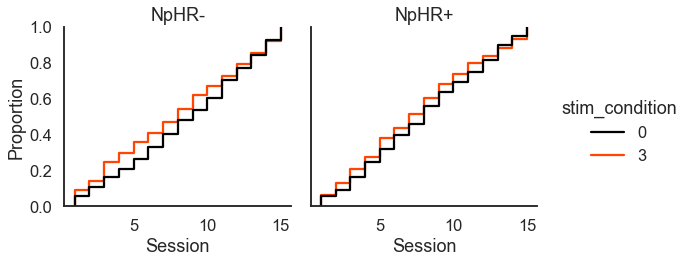

In [30]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)
g = sns.displot(kind='ecdf', data=errors, col='group', x='session_nr', hue='stim_condition',
           palette=['black', 'orangered'], col_order=['CTRL', 'NPHR'], height=4, stat='proportion')
ax = g.axes.flatten()
ax[0].set(title='NpHR-', xlabel='Session')
ax[1].set(title='NpHR+', xlabel='Session')
sns.despine()

## <font color='royalblue'> First session performance

In [67]:
first_session_labels = below15.sort_values(by=['rat','session']).groupby(['rat']).head(1)['session']

In [73]:
first_session_perf = session_perfs[session_perfs['session_nr']==1]
first_session_perf.head()

,group,rat,session,stim_condition,performance,session_nr
0,CTRL,CTRL2,2020-02-07T14_40_27,0,50.000000,1
1,CTRL,CTRL2,2020-02-07T14_40_27,3,71.428571,1
30,CTRL,CTRL3,2020-10-12T13_22_05,0,70.000000,1
31,CTRL,CTRL3,2020-10-12T13_22_05,3,70.000000,1
60,CTRL,CTRL4,2020-11-20T15_12_30,0,90.000000,1


<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

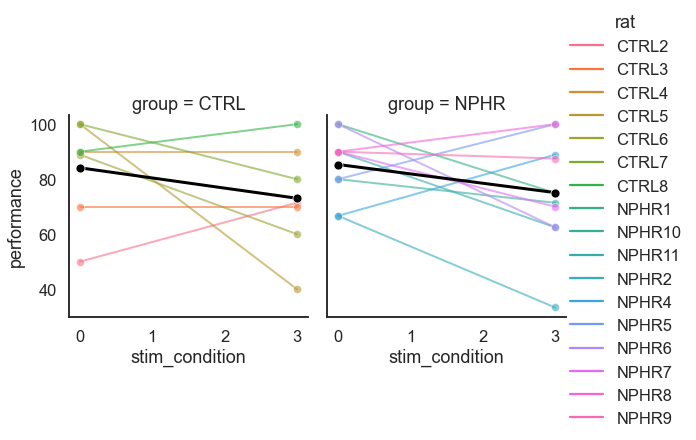

In [82]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(6,4), dpi=300)

sns.set(style="white", context='talk')    
plt.figure(dpi=300)
colors = ['lightgray']*17 # Needs adjusting as more rats are added

g = sns.relplot(
    kind='line', data=first_session_perf, col='group',
    x='stim_condition', y='performance', hue='rat', 
    linewidth=2, marker='o', markersize=8, alpha=.6,
    height=4, aspect=1
)
for group, ax in g.axes_dict.items():
    sns.lineplot(data=first_session_perf[first_session_perf['group']==group], 
                 x='stim_condition', y='performance', marker='o',
                 estimator=np.mean, ci=None, color='black', linewidth=3, ax=ax, legend=False)

sns.despine()